In [1]:
import numpy as np
import time



import matplotlib.pyplot as plt

np.random.seed(42)

%matplotlib inline

# Introduction

In this notebook, we will explore ways to do a regression on a circle. The solutions provided comes from <a href="http://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html">this link</a>. This notebook will be splitted in 3 parts :

<ul>
<li>Preparation of data</li>
<li>Models
    <ul>
    <li>Method 1 : Algebraic approximation</li>
    <li>Method 2 : Least Square Method</li>
    <li>Method 3 : Orthogonal distance regression</li>
    </ul>
</li>
<li>Evaluation
    <ul>
    <li>Accuracy</li>
    <li>Time space</li>
    <li>Other test</li>
    </ul>
</li>
<li>Conclusion</li>
</ul>

# Prepare data

For this project, we will need to create a noisy dataset of points from a circle parameter (center and radius and angle to cover). To do so, we will add to points which belong to a circle some noise randomly generated following the normal law.

In [2]:
def create_datas(alpha_min, alpha_max, r, n_elem, delta_x, delta_y, noise):

    theta_min, theta_max = np.radians(alpha_min), np.radians(alpha_max)   
    theta = (theta_max - theta_min) * np.random.random(n_elem) + theta_min
    noise_x = np.random.normal(0, noise, n_elem)
    noise_y = np.random.normal(0, noise, n_elem)

    x = r * np.cos(theta) + noise_x + delta_x
    y = r * np.sin(theta) + noise_y + delta_y

    return [x, y, r, delta_x, delta_y]

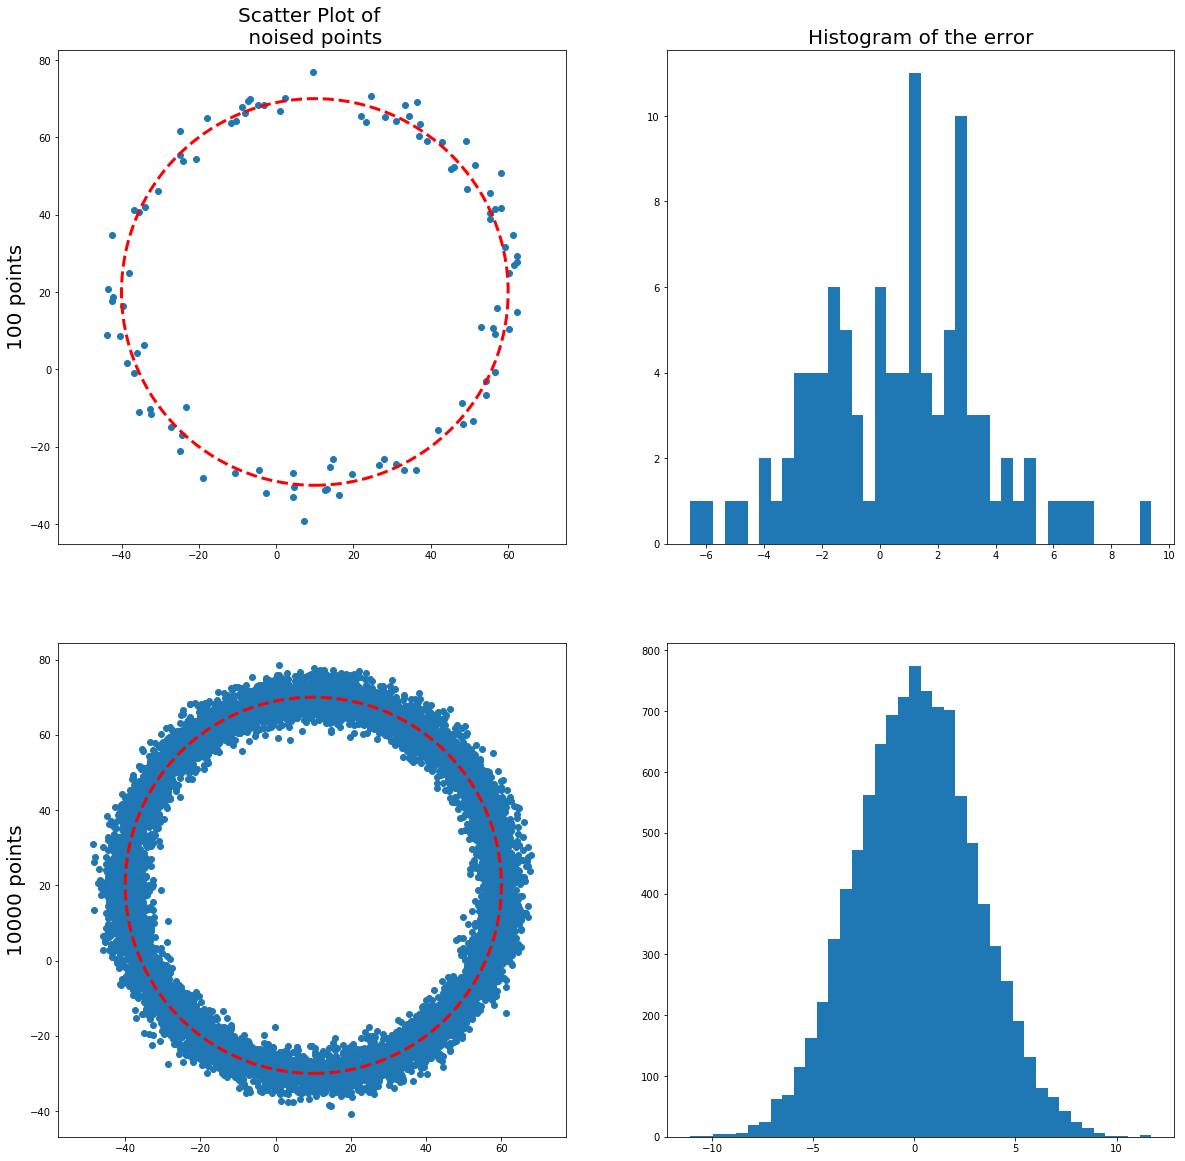

In [3]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(20,20))

x, y, r, delta_x, delta_y = create_datas(alpha_min = 0, 
                                         alpha_max = 360, 
                                         r = 50, 
                                         n_elem = 100, 
                                         delta_x = 10, 
                                         delta_y = 20, 
                                         noise=3)

axes[0, 0].scatter(x, y)
axes[0, 0].add_patch(plt.Circle((delta_x, delta_y), r, color='r', ls= "--", lw=3, fill=False))
axes[0, 0].axis('equal')
axes[0, 0].set_title("Scatter Plot of \n noised points", fontsize=20)
axes[0, 0].set_ylabel("100 points", fontsize=20)

axes[0, 1].hist(np.sqrt((x-delta_x)**2 + (y-delta_y)**2) - r, bins=40)
axes[0, 1].set_title("Histogram of the error", fontsize=20)

x, y, r, delta_x, delta_y = create_datas(alpha_min = 0, 
                                         alpha_max = 360, 
                                         r = 50, 
                                         n_elem = 10000, 
                                         delta_x = 10, 
                                         delta_y = 20, 
                                         noise=3)

axes[1, 0].scatter(x, y)
axes[1, 0].add_patch(plt.Circle((delta_x, delta_y), r, color='r', ls= "--", lw=3, fill=False))
axes[1, 0].axis('equal')
axes[1, 0].set_ylabel("10000 points", fontsize=20)

axes[1, 1].hist(np.sqrt((x-delta_x)**2 + (y-delta_y)**2) - r, bins=40)

plt.show()

# Models

## Algebraic approximation

This method comes from <a href="https://dtcenter.org/met/users/docs/write_ups/circle_fit.pdf">this document</a>. 

For a given set of n point (x_i, y_i). The global objectif on this notebook is to minimize the average distance of all points to the a Circle. For the rest of the notebook, we will call the expected radius R and the center x_c, y_c.

So we want to minimize:

$$
Error = \sum_{k=1}^n (x_k - x_c)^2 + (y_k - y_c)^2 - R^2
$$

Now let's change the base with :

\begin{align}
u_i = x_i - \overline{x} \\
v_i = y_i - \overline{y} \\
u_c = x_c - \overline{x} \\
v_c = y_c - \overline{y} \\
\end{align}

We now have to minimize :

$$
Error = \sum_{k=1}^n ((u_k - u_c)^2 + (v_k - v_c)^2 - R^2)^2
$$

To do so, we have to find values of both partial derivative being =0

\begin{align}
\frac{\partial Error}{\partial R^2} = 0  & \Rightarrow  \sum_{k=1}^n (u_k - u_c)^2 + (v_k - v_c)^2 - R^2 = 0 \\
\frac{\partial Error}{\partial u_c} = 0 & \Rightarrow  \sum_{k=1}^n u_k * ((u_k - u_c)^2 + (v_k - v_c)^2  - R^2) = 0 \\
\frac{\partial Error}{\partial v_c} = 0 & \Rightarrow  \sum_{k=1}^n v_k * ((u_k - u_c)^2 + (v_k - v_c)^2  - R^2) = 0 
\end{align}

Now we can rewrite the equation by defining :

\begin{align}
S_u = \sum_{k=1}^n u_k \\
S_{uu} = \sum_{k=1}^n u_k^2 \\
etc...
\end{align}

and we can rewrite the 2 derivatives as follow :

\begin{align}
    u_cS_{uu} + v_cS_{uv} = \frac12\, (S_{uuu}+S_{uvv}) \\
    u_cS_{uv} + v_cS_{vv} = \frac12\, (S_{vvv}+S_{vuu}) \\
\end{align}

or directly as a Matrix system :

\begin{equation*}
\begin{vmatrix}
S_{uu} & S_{uv} \\
S_{uv} & S_{vv} \\
\end{vmatrix} \times \begin{vmatrix}
u_c \\ 
v_c \\
\end{vmatrix} = \frac12\ \begin{vmatrix}
S_{uuu}+S_{uvv} \\ 
S_{vvv}+S_{vuu} \\
\end{vmatrix}
\end{equation*}


Now we have the center and we need the radius. This can be done by merging all 3 derivative to reach the following equation :

$$
R = u_c^2+ v_c^2 + \frac{S_{uu} + S_{vv}}{N}
$$

Now we can just implement it in Python and let a solver solve the 3 equations.

In [4]:
def method_1(x, y):
    x_m = x.mean()
    y_m = y.mean()

    u = x - x_m
    v = y - y_m

    Suv  = sum(u*v)
    Suu  = sum(u**2)
    Svv  = sum(v**2)
    Suuv = sum(u**2 * v)
    Suvv = sum(u * v**2)
    Suuu = sum(u**3)
    Svvv = sum(v**3)

    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = scipy.linalg.solve(A, B)

    xc = x_m + uc
    yc = y_m + vc

    Ri = np.sqrt((x-xc)**2 + (y-yc)**2)
    R = Ri.mean()
    error = sum((Ri-R)**2)

    return R, xc, yc, error

R_1, xc_1, yc_1, error_1 = method_1(x, y)
    
print("R : {:.3f} - Center = ({:.3f}, {:.3f})".format(R_1, xc_1, yc_1))

R : 50.097 - Center = (10.010, 19.997)


## Least Square Method

This method is more simple. We will use a solver to reduce the Mean Squared error. Based on the variation of the radius between each point and the center, the idea is to find a tuple of point (x_c, y_c) where 

$$
\delta(x_c, y_c) = R_k^2(x_c, y_c) - \overline{R_k^2(x_c, y_c)} 
$$

with 
$$
R_k^2(x_c, y_c) = (x_k - x_c)^2 + (y_k - y_c)^2
$$

The understanding of this objective is quite simple. If all point belong to an unknown circle, the best fit will lead to a center position where all points are at the same distance to this one. The variation will be 0. After that, to get the radius, we just need to compute the average distance of points to the center. 

A good start point would be the center of all points. If we have a complete circle, it will be quite good. If we have only an arc or the circle, for sure the prediction will be quite far and during the fit, we may end in a local minimum (this will be tried later one).

To minimize this objective, the module leastsq is the perfect one and leads to the following code

In [5]:
def f_2(c, X, Y):
    """ calculate the variance of the squared distance between the data points and the center of the circle at c=(xc, yc) """
    Ri = (X-c[0])**2 + (Y-c[1])**2
    return Ri - Ri.mean()

def method_2(x, y):
    x_m = x.mean()
    y_m = y.mean()

    center_estimate = x_m, y_m
    center, ier = optimize.leastsq(f_2, center_estimate, args=(x, y))

    xc, yc = center
    Ri = np.sqrt((x-xc)**2 + (y-yc)**2)
    R = Ri.mean()
    error = sum((Ri - R)**2)

    return R, xc, yc, error
    
R_2, xc_2, yc_2, error_2 = method_2(x, y)
    
print("R : {:.3f} - Center = ({:.3f}, {:.3f})".format(R_2, xc_2, yc_2))

R : 50.097 - Center = (10.010, 19.997)


## Orthogonal distance regression

Similarly to the previous implementation, we will use now the orthogonal distance regression. It works the same as Linear Regression but for linear or non-linear function. We just have to provide the distance to minimize based on parameters (in our case center and radius) and let the algorithm minimize the error (in our case the MSE of points to the estimated circle)

In [6]:
def f_3(beta, x):
    """ return the distance point to estimated circle """
    return (x[0]-beta[0])**2 + (x[1]-beta[1])**2 - beta[2]**2

def method_3(x, y):
    x_m = x.mean()
    y_m = y.mean()
    
    R_m = np.sqrt((x-x_m)**2 + (y-y_m)**2).mean()
    beta0 = [ x_m, y_m, R_m]

    lsc_data  = odr.Data(np.row_stack([x, y]), y=1)
    lsc_model = odr.Model(f_3, implicit=True)
    lsc_odr   = odr.ODR(lsc_data, lsc_model, beta0)
    lsc_out   = lsc_odr.run()

    xc, yc, R = lsc_out.beta
    Ri = np.sqrt((x-xc)**2 + (y-yc)**2)
    error = sum((Ri - R)**2)

    return R, xc, yc, error
    
R_3, xc_3, yc_3, error_3 = method_3(x, y)
    
print("R : {:.3f} - Center = ({:.3f}, {:.3f})".format(R_3, xc_3, yc_3))

R : 50.097 - Center = (9.997, 19.991)


# Evaluation

## Accuracy

For a known circle, we can look at both model predictions compare to the real circle.

Real Values
R : 50.000 - Center = (10.000, 20.000) 

Model 1
R : 49.937 - Center = (9.525, 20.010 - Error = 2074.987) 

Model 2
R : 49.937 - Center = (9.525, 20.010 - Error = 2074.987) 

Model 3
R : 49.948 - Center = (9.560, 19.933 - Error = 2074.604) 



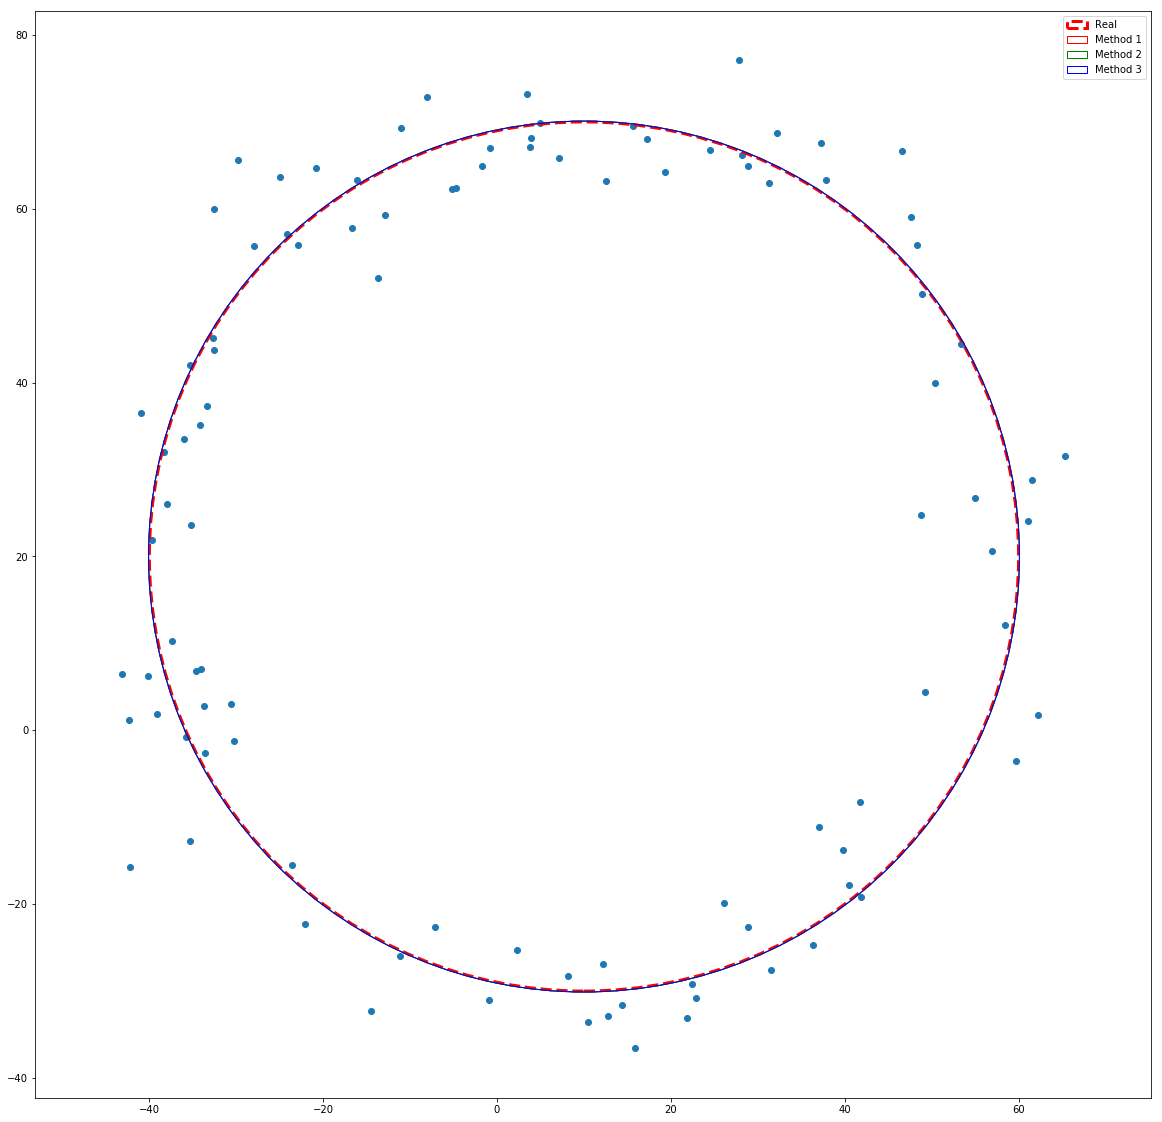

In [7]:
x, y, r, delta_x, delta_y = create_datas(alpha_min = 0, 
                                         alpha_max = 360, 
                                         r = 50, 
                                         n_elem = 100, 
                                         delta_x = 10, 
                                         delta_y = 20, 
                                         noise=5)

print("Real Values\nR : {:.3f} - Center = ({:.3f}, {:.3f}) \n".format(r, delta_x, delta_y))

r1 = method_1(x, y)
print("Model 1\nR : {:.3f} - Center = ({:.3f}, {:.3f} - Error = {:.3f}) \n".format(*r1))

r2 = method_2(x, y)
print("Model 2\nR : {:.3f} - Center = ({:.3f}, {:.3f} - Error = {:.3f}) \n".format(*r2))

r3 = method_3(x, y)
print("Model 3\nR : {:.3f} - Center = ({:.3f}, {:.3f} - Error = {:.3f}) \n".format(*r3))

fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y)
ax.add_patch(plt.Circle((delta_x, delta_y), r, color='r', ls= "--", lw=3, fill=False, label="Real"))
ax.add_patch(plt.Circle((xc_1, yc_1), R_1, color='r', fill=False, label="Method 1"))
ax.add_patch(plt.Circle((xc_2, yc_2), R_2, color='g', fill=False, label="Method 2"))
ax.add_patch(plt.Circle((xc_3, yc_3), R_3, color='b', fill=False, label="Method 3"))
plt.axis('equal')
plt.legend()
plt.show()

As we saw in the first part, with a few number of points, we may have a noise not centered in 0 and predict a circle which better fit the data than the original circle. This is the case on this one with a x_c slightly smaller (-0.5). 

What we can see it that Model 1 and 2 predict exactly the same circle and the 3rd one is slightly different but with less error.

Nevertheless, we can say that both prediction are good on this example. What may be different for the 3 method is the runtime which will be explored now

## time

In [8]:
def timed(fun, *args):
    n=3
    s = time.time()
    for i in range(n):
        r = fun(*args)
    t = (time.time()-s)/n
#     print('{} execution took {:.2E} seconds.'.format(fun.__name__, t))
    return [r, t]

t_1, t_2, t_3 = [], [], []
n_space = [int(n) for n in np.logspace(1.0, 4.5, num=100)]

for n in n_space:   
    x, y, r, delta_x, delta_y = create_datas(alpha_min = 0, 
                                             alpha_max = 360, 
                                             r = 50, 
                                             n_elem = n, 
                                             delta_x = 10, 
                                             delta_y = 20, 
                                             noise=5)
    r1, t = timed(method_1, x, y)
    t_1.append(t)
    r2, t = timed(method_2, x, y)
    t_2.append(t)
    r3, t = timed(method_3, x, y)
    t_3.append(t)

In [9]:
from sklearn.linear_model import LinearRegression

mdl = LinearRegression()

mdl.fit(np.array(n_space).reshape(-1, 1), np.array(t_1).reshape(-1, 1))
y_1 = mdl.predict(np.array(n_space).reshape(-1, 1))
print("model 1 : {:0.3E} x + {:0.3E}".format(mdl.coef_[0][0], mdl.intercept_[0]))

mdl.fit(np.array(n_space).reshape(-1, 1), np.array(t_2).reshape(-1, 1))
y_2 = mdl.predict(np.array(n_space).reshape(-1, 1))
print("model 2 : {:0.3E} x + {:0.3E}".format(mdl.coef_[0][0], mdl.intercept_[0]))

mdl.fit(np.array(n_space).reshape(-1, 1), np.array(t_3).reshape(-1, 1))
y_3 = mdl.predict(np.array(n_space).reshape(-1, 1))
print("model 3 : {:0.3E} x + {:0.3E}".format(mdl.coef_[0][0], mdl.intercept_[0]))

model 1 : 1.143E-06 x + 6.258E-05
model 2 : 2.022E-07 x + 1.260E-04
model 3 : 8.584E-06 x + 1.790E-03


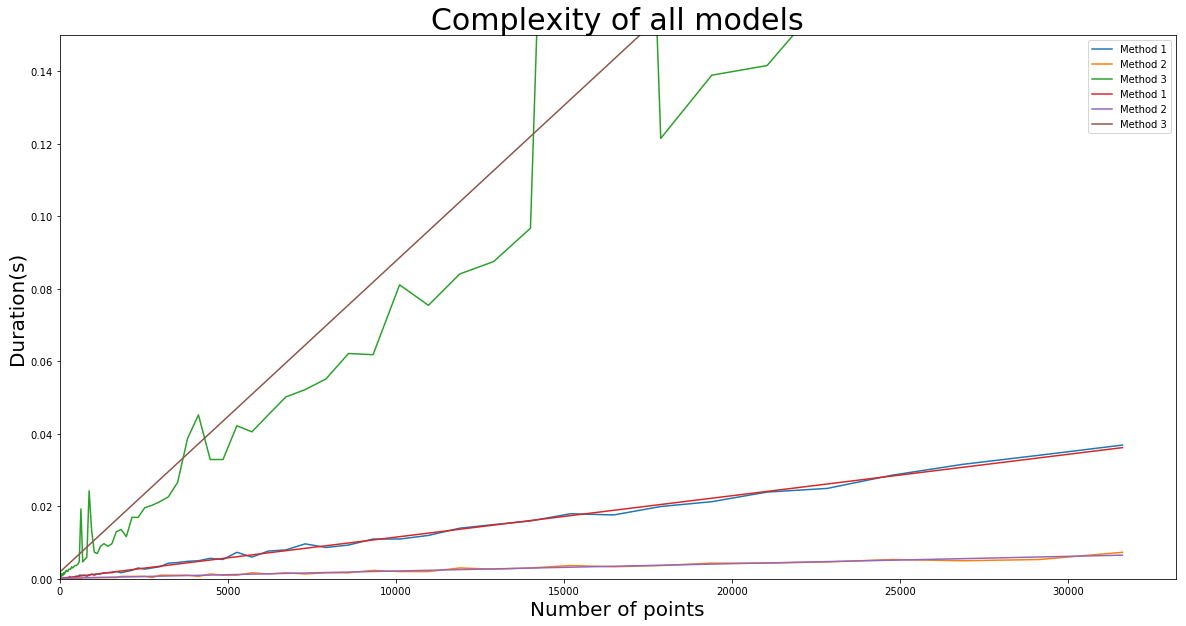

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(n_space, t_1, label = "Method 1")
plt.plot(n_space, t_2, label = "Method 2")
plt.plot(n_space, t_3, label = "Method 3")

plt.plot(n_space, y_1, label = "Method 1")
plt.plot(n_space, y_2, label = "Method 2")
plt.plot(n_space, y_3, label = "Method 3")
plt.title("Complexity of all models", fontsize=30)
plt.xlabel("Number of points", fontsize=20)
plt.ylabel("Duration(s)", fontsize=20)
plt.ylim(0, 0.15)
plt.xlim(0)
plt.legend()
plt.show()

We can see that the computationnal time is linear but with a slope very different. The model 2 is around 5 times faster than model 1 and 50 times faster than model 3.

Now we can look at the impact on some parameter on the prediction.

## Test on more complex one

In [11]:
def test(alpha_min, alpha_max, r, nb_pts, noise, delta_x, delta_y):

    theta_min, theta_max = np.radians(alpha_min), np.radians(alpha_max)   
    theta = (theta_max - theta_min) * np.random.random(nb_pts) + theta_min
    noise_x = np.random.normal(0, noise, nb_pts)
    noise_y = np.random.normal(0, noise, nb_pts)

    x = r * np.cos(theta) + noise_x + delta_x
    y = r * np.sin(theta) + noise_y + delta_y

    r1 = method_1(x, y)
    r2 = method_2(x, y)
    r3 = method_3(x, y)
    real = [r, delta_x, delta_y]
    
    return [x, y, r1, r2, r3, real]

### Impact of the covered angle

Now let's look at a prediction with nearly no noise but points on the complete circlu or only an arc.

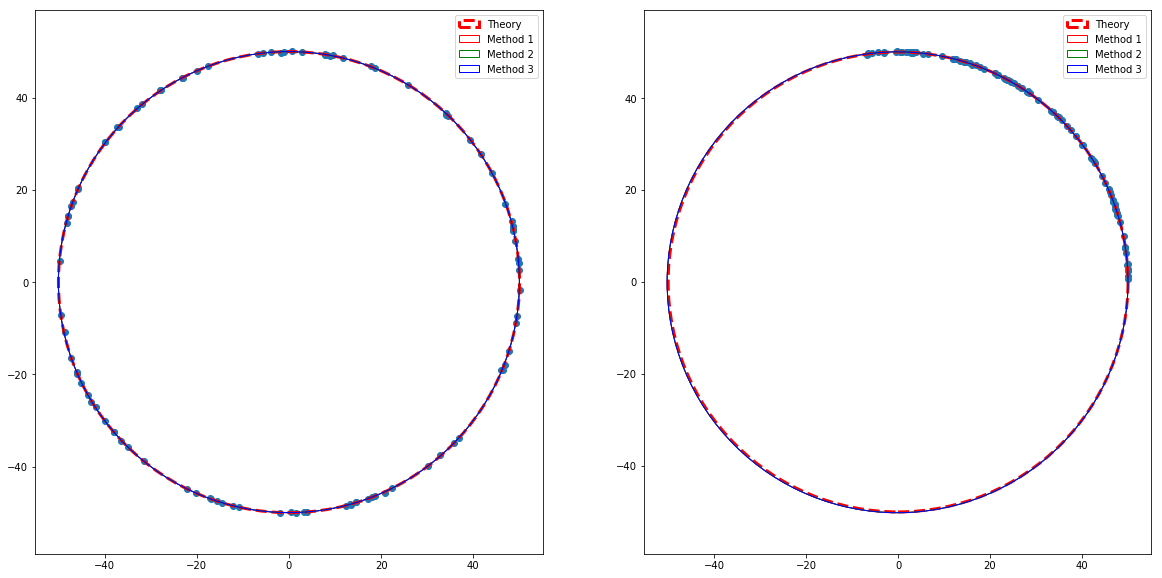

In [12]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=100, noise=0.1, delta_x=0, delta_y=0)

ax1.scatter(x, y)
ax1.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax1.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
ax1.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
ax1.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax1.axis('equal')
ax1.legend()

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=100, r=50, nb_pts=100, noise=0.1, delta_x=0, delta_y=0)

ax2.scatter(x, y)
ax2.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax2.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
ax2.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
ax2.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax2.axis('equal')
ax2.legend()

plt.show()

In both cases, the prediction is good. This is quite logical as we have no noise. Now let's look at the impact of the number of points. If we have more noise, we may have a change of parameter

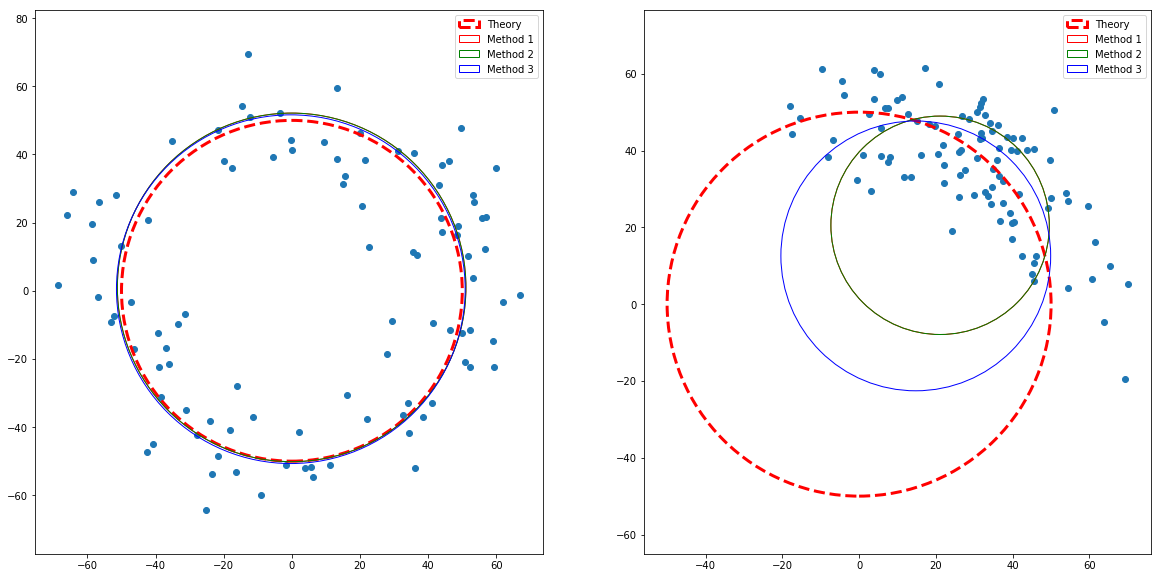

In [13]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=100, noise=10, delta_x=0, delta_y=0)

ax1.scatter(x, y)
ax1.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax1.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
ax1.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
ax1.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax1.axis('equal')
ax1.legend()

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=100, r=50, nb_pts=100, noise=10, delta_x=0, delta_y=0)

ax2.scatter(x, y)
ax2.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax2.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
ax2.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
ax2.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax2.axis('equal')
ax2.legend()

plt.show()

We see that if we have more noise on a complete circle, the prediction remain quite fine but with a partial angle it's completely different as the cloud of point is "oval"

### Impact of the number of points

To this check, we will increase the noise to see changes.

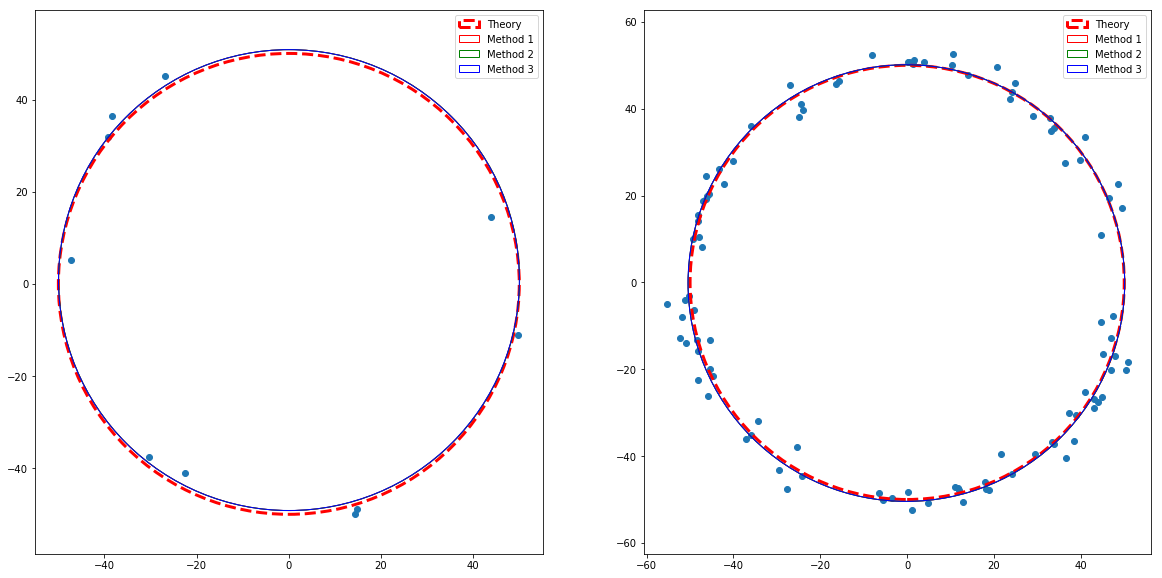

In [14]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=10, noise=2, delta_x=0, delta_y=0)

ax1.scatter(x, y)
ax1.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax1.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
ax1.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
ax1.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax1.axis('equal')
ax1.legend()

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=100, noise=2, delta_x=0, delta_y=0)

ax2.scatter(x, y)
ax2.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax2.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
ax2.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
ax2.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax2.axis('equal')
ax2.legend()

plt.show()

The number of point impact the prediction as we saw on the first part. Our noise is not centered on 0 and may lead to a shift of the center and a change of radius.

### Impact of the number of points and noise

Finally, we can look at the impact of the number of points and the noise. Logically, the more point we have, more better will be our prediction and the more noise we can accept as the noise will be shared following a Normal Law.

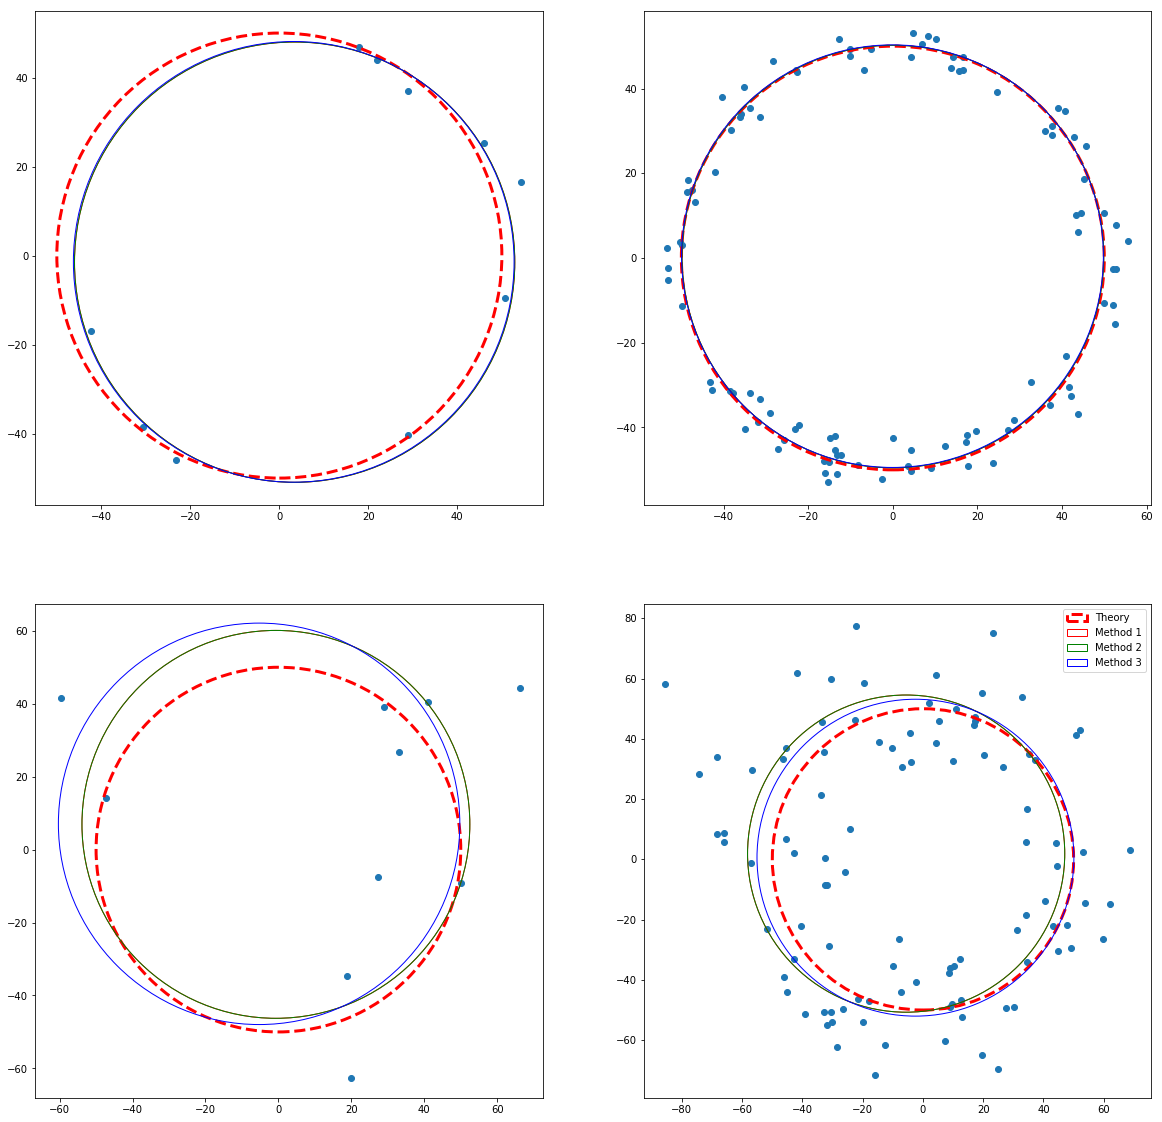

In [18]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(20,20))

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=10, noise=3, delta_x=0, delta_y=0)

axes[0, 0].scatter(x, y)
axes[0, 0].add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
axes[0, 0].add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
axes[0, 0].add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
axes[0, 0].add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
axes[0, 0].axis('equal')

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=100, noise=3, delta_x=0, delta_y=0)

axes[0, 1].scatter(x, y)
axes[0, 1].add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
axes[0, 1].add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
axes[0, 1].add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
axes[0, 1].add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
axes[0, 1].axis('equal')

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=10, noise=15, delta_x=0, delta_y=0)

axes[1, 0].scatter(x, y)
axes[1, 0].add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
axes[1, 0].add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
axes[1, 0].add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
axes[1, 0].add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
axes[1, 0].axis('equal')

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=360, r=50, nb_pts=100, noise=15, delta_x=0, delta_y=0)

axes[1, 1].scatter(x, y)
axes[1, 1].add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
axes[1, 1].add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', fill=False, label="Method 1"))
axes[1, 1].add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', fill=False, label="Method 2"))
axes[1, 1].add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
axes[1, 1].axis('equal')

plt.legend()
plt.show()

### Worst Case

Now we saw all the parameter and the impact it may have so we can look at the worst case and see which one works the best.

We know that the worst case will be with few points, lot of noise, and a small angle

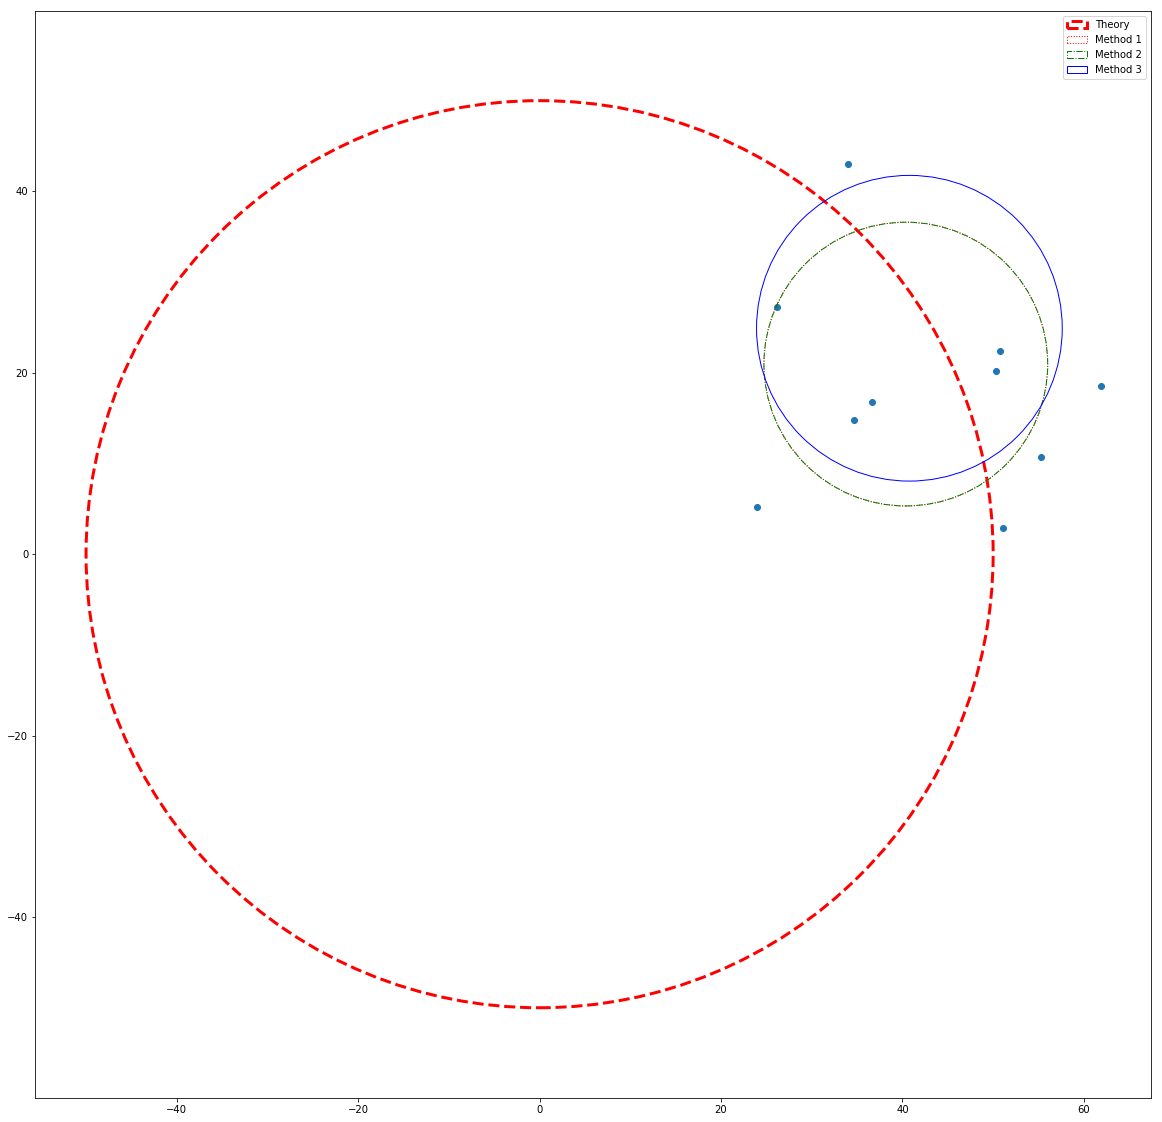

In [16]:
plt.clf()
fig, ax1 = plt.subplots(figsize=(20,20))

x, y, r1, r2, r3, real = test(alpha_min=0, alpha_max=50, r=50, nb_pts=10, noise=11, delta_x=0, delta_y=0)

ax1.scatter(x, y)
ax1.add_patch(plt.Circle((real[1], real[2]), real[0], color='r', ls= "--", lw=3, fill=False, label="Theory"))
ax1.add_patch(plt.Circle((r1[1], r1[2]), r1[0], color='r', ls=":", fill=False, label="Method 1"))
ax1.add_patch(plt.Circle((r2[1], r2[2]), r2[0], color='g', ls="-.", fill=False, label="Method 2"))
ax1.add_patch(plt.Circle((r3[1], r3[2]), r3[0], color='b', fill=False, label="Method 3"))
ax1.axis('equal')

plt.legend()
plt.show()

No models find the correct prediction and are far from it but in tuch case, it's also difficult to imagine that a circle has to be found.

# Conclusion

In this notebook, we explore a way to do a regression on a Circle. We found 3 methods :
 - 1 using algebra to minimize the error to the circle. This one should be the most accurate one
 - 2 using method to minimize the error in an iterative way
 
Based on the prediction, we can see that the best one is the method 2 which is the fastest and the more stable (nearly always converge to the exact solution found by the method algebraic).

In the future, I'll probably create a small implementation for Sk-Learn with a choice of method.